# Challenge 2: Data Science (Cryptocurrency) Assessment

## Task One:

### Use a public blockchain API (e.g. Etherscan or Blockchain.com) to:

Query recent transactions of a crypto wallet address (of your choice)

Plot a simple graph:<br>
Nodes = Wallet addresses<br>
Edges = Transactions<br>

Focus on a small subset (e.g. 10–20 transactions) for clarity

(Bonus) Provide insights on the activity / detection of possible illicit activity


In [56]:
# Importing the necessary libraries/fuctions/tools for both tasks
from requests import get
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import networkx as nx
from matplotlib.patches import FancyArrowPatch
import numpy as np

In [57]:
# Defining key variables
my_api_key="1FHJBGBXCZ92F5WP6XCGCNXEQEWKEJE71U"
crypto_wallet_address="0xdadB0d80178819F2319190D340ce9A924f783711"
number_of_transactions=15

In [58]:
# Function to create api url to get data, in case of change in any of the variables
def create_transaction_url(address,api_key,number_of_transactions):
    no_of_transactions=str(number_of_transactions)
    url="https://api.etherscan.io/v2/api?chainid=1&module=account&action=txlist&address="+address+"&startblock=0&endblock=99999999&page=1&offset="+no_of_transactions+"&sort=desc&apikey="+api_key
    return url

# Function that gets the data from the api itself
def get_latest_account_transactions(address,api_key,number_of_transactions):
    transactions_url=create_transaction_url(address,api_key,number_of_transactions)
    response=get(transactions_url)
    data=response.json()["result"]
    count=1
    return data

In [59]:
# Function call
data=get_latest_account_transactions(crypto_wallet_address,my_api_key,number_of_transactions)

In [60]:
# Extracting relevant attributes from the data into a new dataframe
to_addresses,from_addresses,transaction_values,transaction_dates,transaction_times=[],[],[],[],[]
for i in data:
    to_addresses.append(i["to"])
    from_addresses.append(i["from"])
    value=int(i["value"])/10**18
    transaction_values.append(value)
    time=datetime.fromtimestamp(int(i["timeStamp"]))
    transaction_dates.append(str(time.date()))
    transaction_times.append(str(time.time()))

dataframe=pd.DataFrame({"From Address":from_addresses,"To Address":to_addresses, "Transaction Value (ETH)":transaction_values,"Transaction Date":transaction_dates,"Transaction Time":transaction_times})

In [61]:
# Entering nodes and edges of the graph to be plotted using the networkx library
G=nx.MultiGraph()
G.add_nodes_from(dataframe["To Address"])
G.add_nodes_from(dataframe["From Address"])
edges=list(zip(dataframe["From Address"],dataframe["To Address"],dataframe["Transaction Value (ETH)"]))
G.add_edges_from([(from_ad,to_ad,{"weight":value}) for from_ad,to_ad,value in edges])

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 1]

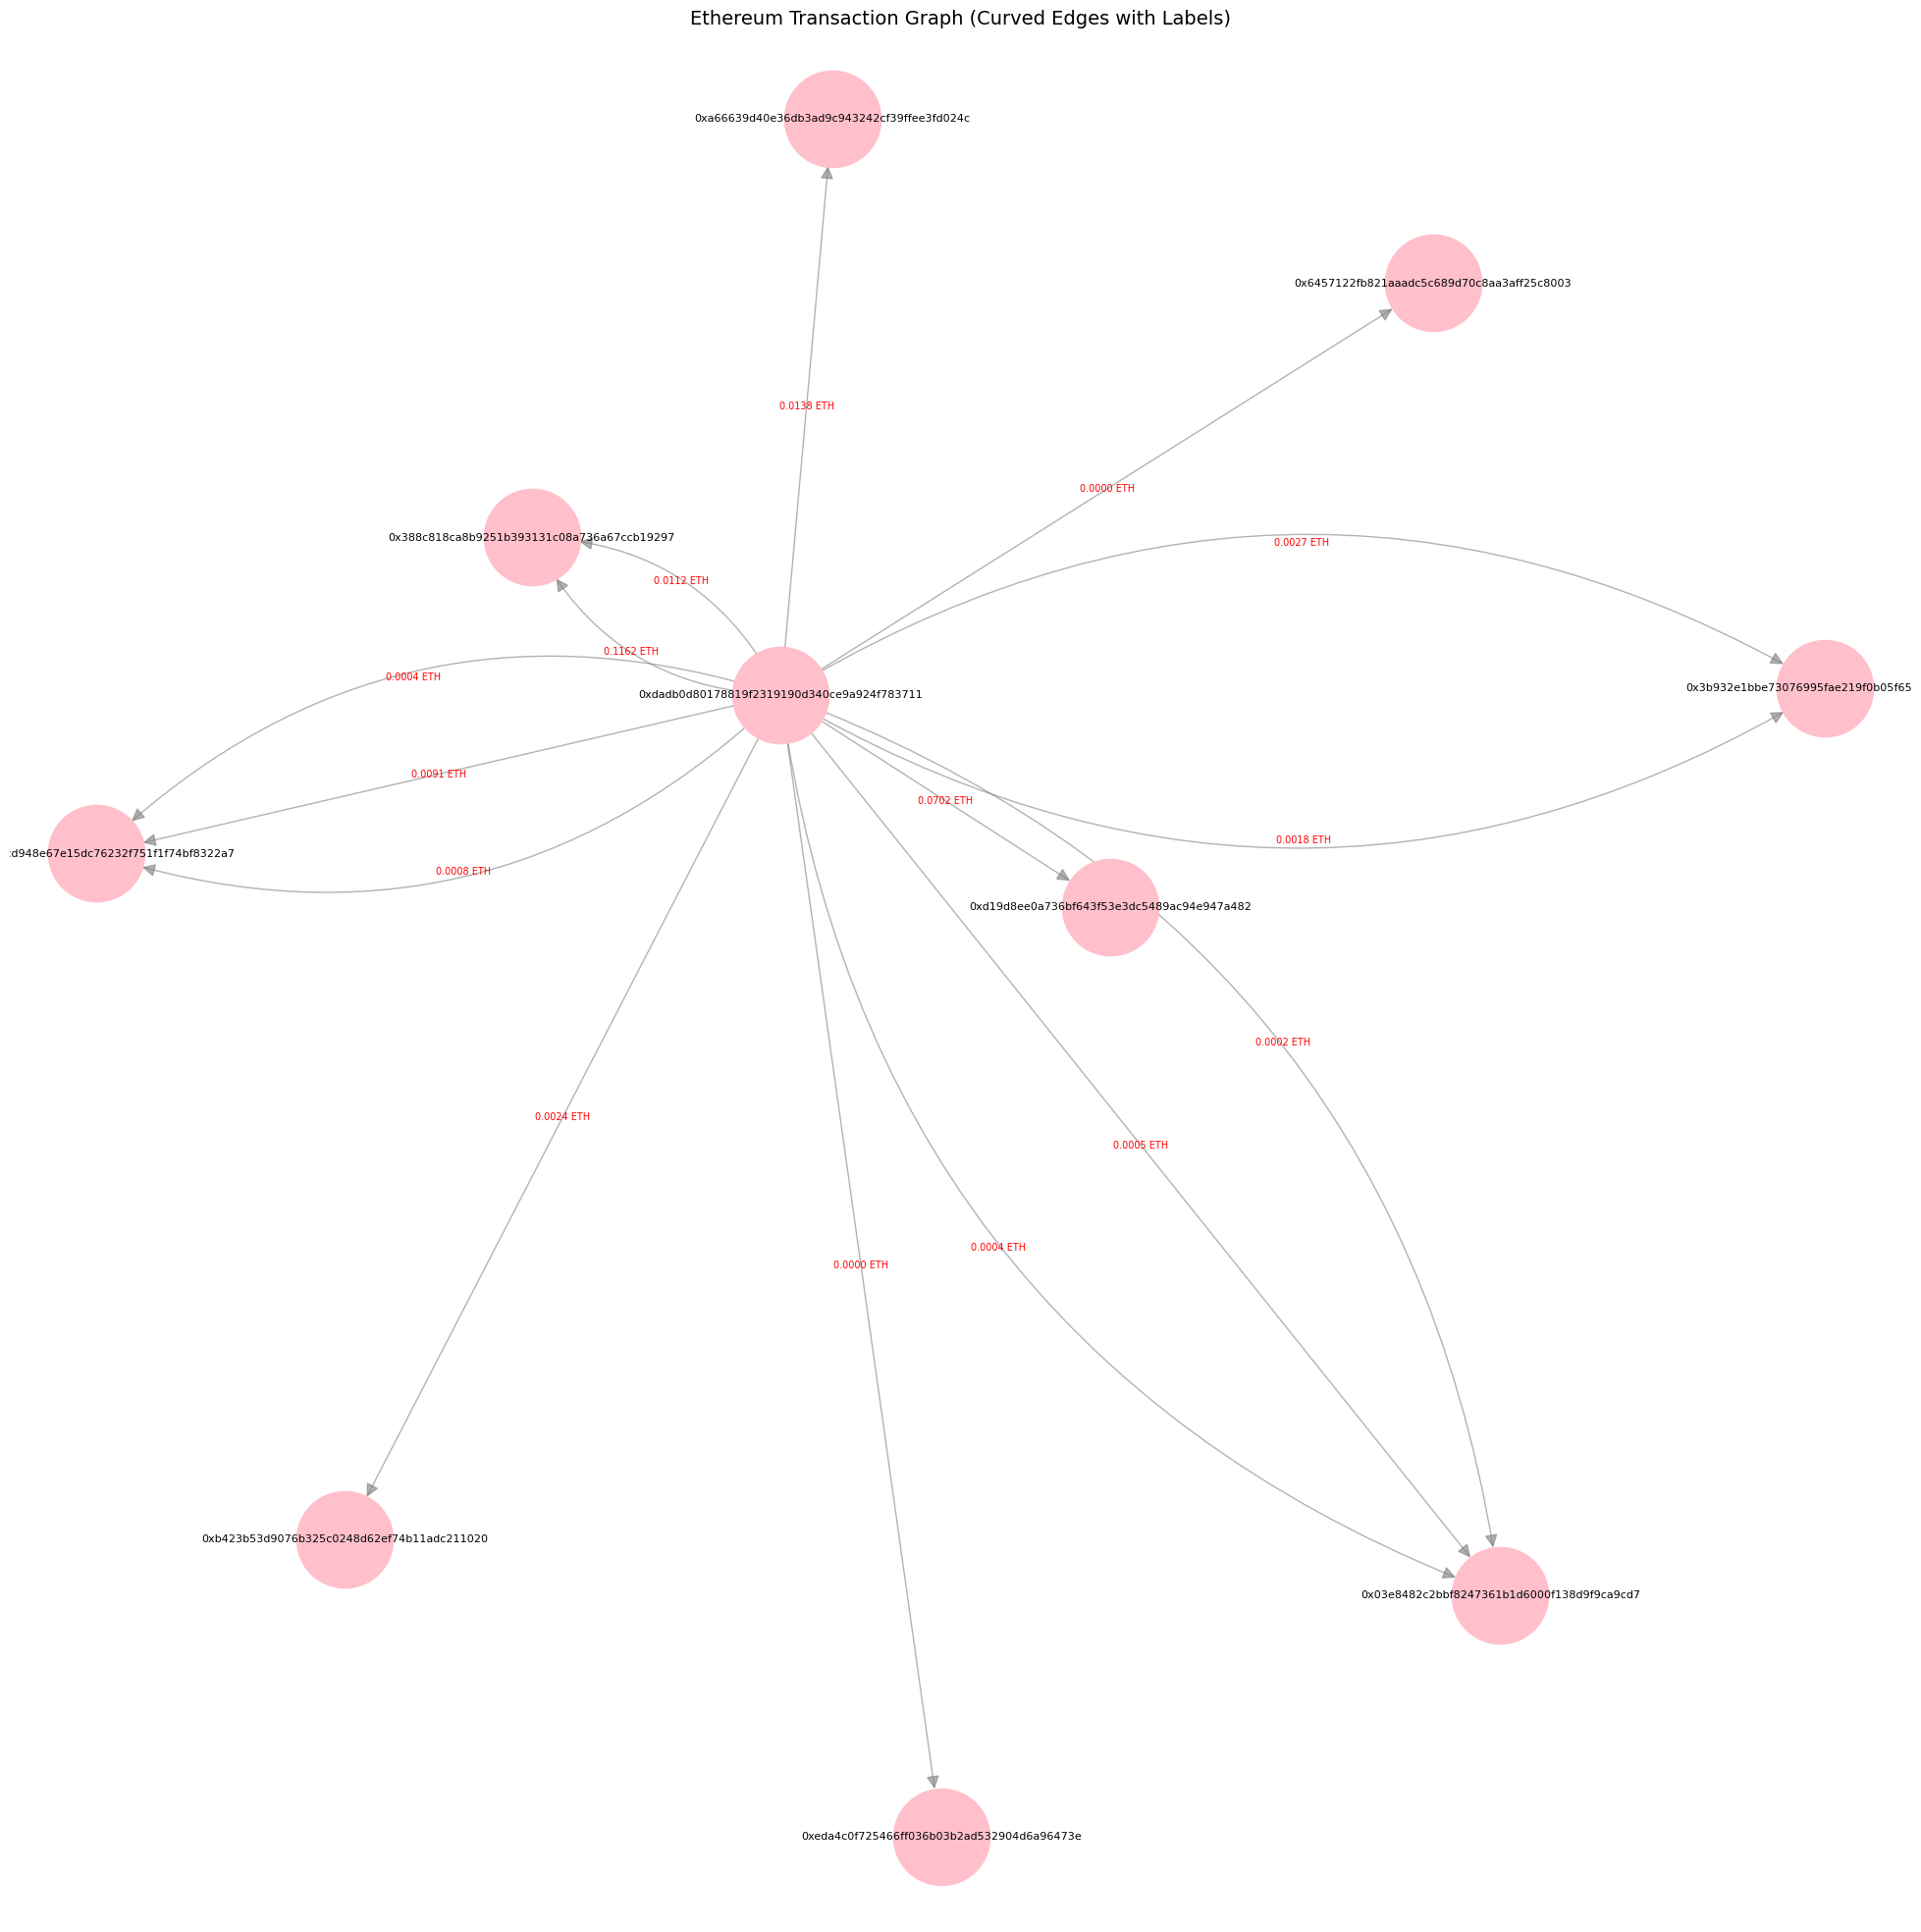

In [62]:
# Code that draws out each edge neatly and clearly, with assistance from chatgpt

# Function that calculates the Bezier midpoint on a line/curve in order to position the transaction value as a label
def curved_label_pos(p1, p2, rad):
    x0, y0 = p1
    x1, y1 = p2
    cx, cy = (x0 + x1)/2 - rad*(y1 - y0), (y0 + y1)/2 + rad*(x1 - x0)
    t = 0.5
    xm = (1-t)**2 * x0 + 2*(1-t)*t*cx + t**2 * x1
    ym = (1-t)**2 * y0 + 2*(1-t)*t*cy + t**2 * y1
    return xm, ym


graph_layout = nx.spring_layout(G,seed=9500)
fig, ax = plt.subplots(figsize=(25,25))
nx.draw_networkx_nodes(G, graph_layout, node_size=5000, node_color="pink")
nx.draw_networkx_labels(G, graph_layout, font_size=8)

# Counting parallel edged between pairs of nodes
edge_count = {}
for u, v, d in G.edges(data=True):
    key = tuple(sorted([u, v]))
    edge_count[key] = edge_count.get(key, 0) + 1

edge_index = {}

# Drawing edges and applying labels
for u, v, d in G.edges(data=True):
    key = tuple(sorted([u, v]))
    idx = edge_index.get(key, 0)
    total = edge_count[key]

    # Assign curvature
    if total == 1:
        rad = 0
    else:
        rad = -0.3 + 0.6 * idx / (total - 1)
    edge_index[key] = idx + 1

    # Draw edge as arrow
    arrow = FancyArrowPatch(
        posA=graph_layout[u],
        posB=graph_layout[v],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="<|-",
        lw=max(1, d["weight"]*2),
        color="0.5",
        alpha=0.6,
        mutation_scale=20,
        shrinkA=35
    )
    ax.add_patch(arrow)

    # Compute label position along the curve
    xm, ym = curved_label_pos(graph_layout[u], graph_layout[v], rad)
    ax.text(xm, ym, f'{d["weight"]:.4f} ETH', fontsize=7, color="red",
            horizontalalignment='center', verticalalignment='center')

plt.title("Ethereum Transaction Graph (Curved Edges with Labels)", fontsize=14)
plt.axis("off")
plt.savefig("ethereum_transaction_graph.png", dpi=300, bbox_inches="tight")
plt.show()


In [63]:
# Gathering insights/interesting points from the transaction data
insights=dataframe[['Transaction Date','Transaction Time']]
insights.head(15)

,Transaction Date,Transaction Time
0,2025-09-17,05:34:59
1,2025-09-17,05:34:59
2,2025-09-17,05:34:59
3,2025-09-17,05:34:59
4,2025-09-17,05:34:23
5,2025-09-17,05:34:23
6,2025-09-17,05:34:23
7,2025-09-17,05:34:23
8,2025-09-17,05:34:23
9,2025-09-17,05:33:59


An insight/interesting thing that I noticed about the transactions is that looking at the transaction dates and times, we can see that multiple transactions on the same day and time took place within 1 second. This likely means that these transactions are not likely to be done by a human, and instead done by a bot or an automated system when a certain condition is triggered. However, this alone is not an indicator of illicit activity.

References:<br>
https://docs.etherscan.io/<br>
https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx<br>
https://networkx.org/documentation/stable/tutorial.html

## Task Two:

### Perform basic forensics analysis:
Select a crypto token of your choice where there is a time period (e.g. 7-day or 30-day) with possible unusual market activity / illicit activity (e.g. pump and dump) involved

Highlight movements that are potential red flags

Results can be in the form of:<br>
Time series with highlighted anomalies (e.g. volume spikes) and/or;<br>
Histograms of transaction sizes or times and/or;<br>
Wallet-level heatmaps and/or;<br>
Annotated charts with labels like “suspicious activity detected”<br>

In [64]:
# Libra Token Contract
token_contract_address="0xfe5F141Bf94fE84bC28deD0AB966c16B17490657"

number_of_token_transactions=10000

In [65]:
# Functions similar to earlier, but now edited to collect token transactions

def create_token_transfer_url(address,api_key,number_of_token_transactions):
    no_of_transactions=str(number_of_token_transactions)
    url="https://api.etherscan.io/api?module=account&action=tokentx&contractaddress="+address+"&page=1&offset="+no_of_transactions+"&startblock=11500000&endblock=40000000&sort=asc&apikey="+api_key
    return url
    
def get_latest_token_transactions(address,api_key,number_of_transactions):
    transactions_url=create_token_transfer_url(address,api_key,number_of_transactions)
    response=get(transactions_url)
    data=response.json()["result"]
    count=1
    return data

In [66]:
t_data=get_latest_token_transactions(token_contract_address,my_api_key,number_of_token_transactions)

In [67]:
# Extracting relevant attributes from the data into a new dataframe
t_to_addresses,t_from_addresses,t_transaction_values,t_transaction_timestamp=[],[],[],[]
for i in t_data:
    t_to_addresses.append(i["to"])
    t_from_addresses.append(i["from"])
    t_value=int(i["value"])/10**18
    t_transaction_values.append(t_value)
    t_timestamp=datetime.fromtimestamp(int(i["timeStamp"]))
    t_transaction_timestamp.append(t_timestamp)
    
t_dataframe=pd.DataFrame({"From Address":t_from_addresses,"To Address":t_to_addresses, "Transaction Value (ETH)":t_transaction_values,"Transaction Timestamp":t_transaction_timestamp})

In [68]:
# Ensuring 'Transaction Timestamp' column data is in the timestamp data type, for filtering
t_dataframe['Transaction Timestamp'] = pd.to_datetime(t_dataframe['Transaction Timestamp'])

In [69]:
# Filtering and extracting transaction data from Jan 2021
transactions_in_jan_2021 = t_dataframe[(t_dataframe['Transaction Timestamp'].dt.year == 2021) & (t_dataframe['Transaction Timestamp'].dt.month == 1)]

In [70]:
# Grouping and aggregating relevant data by day in Jan 2021
aggregation_by_day=transactions_in_jan_2021.groupby(pd.Grouper(key="Transaction Timestamp",freq="D")).agg(
                                                                                                    Total_Volume=("Transaction Value (ETH)","sum"),
                                                                                                    Transaction_Count=("Transaction Value (ETH)","count")).reset_index()


Text(0.5, 1.0, 'Daily Transaction Volume (Jan 2021)')

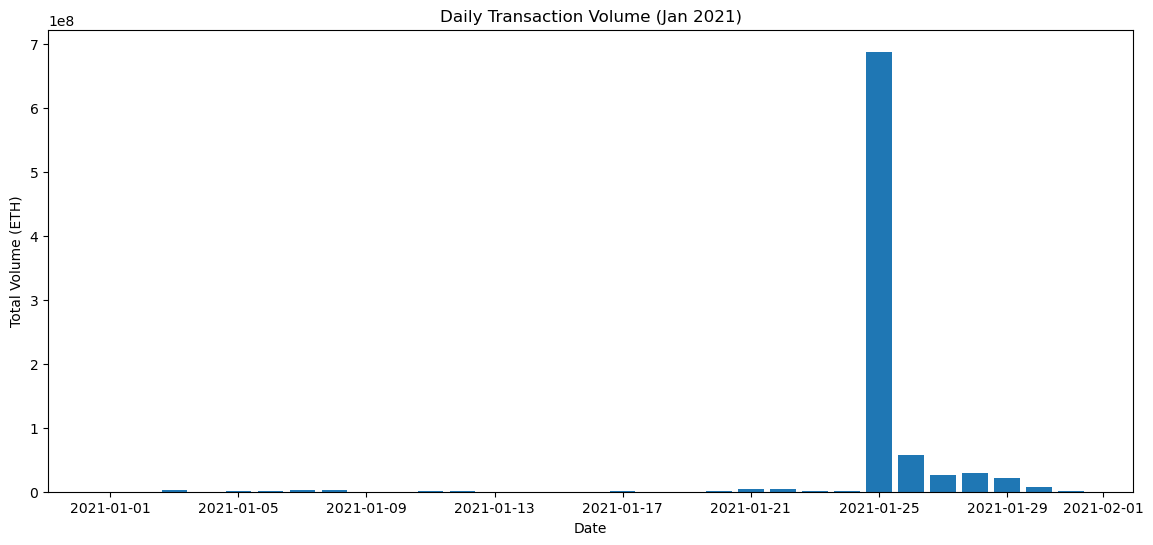

In [71]:
plt.figure(figsize=(14,6))
plt.bar(aggregation_by_day["Transaction Timestamp"],aggregation_by_day["Total_Volume"])
plt.xlabel("Date")
plt.ylabel("Total Volume (ETH)")
plt.title("Daily Transaction Volume (Jan 2021)")

Text(0.5, 1.0, 'Daily Transaction Count (Jan 2021)')

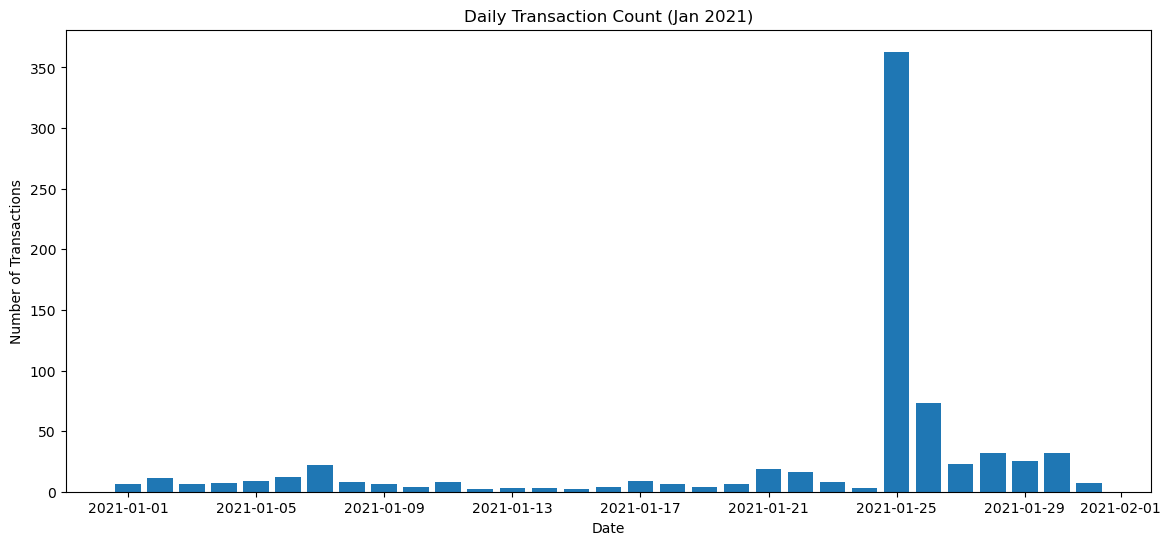

In [72]:
plt.figure(figsize=(14,6))
plt.bar(aggregation_by_day["Transaction Timestamp"],aggregation_by_day["Transaction_Count"])
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.title("Daily Transaction Count (Jan 2021)")

Text(0.5, 1.0, 'Histogram of Transaction Sizes (Jan 2021)')

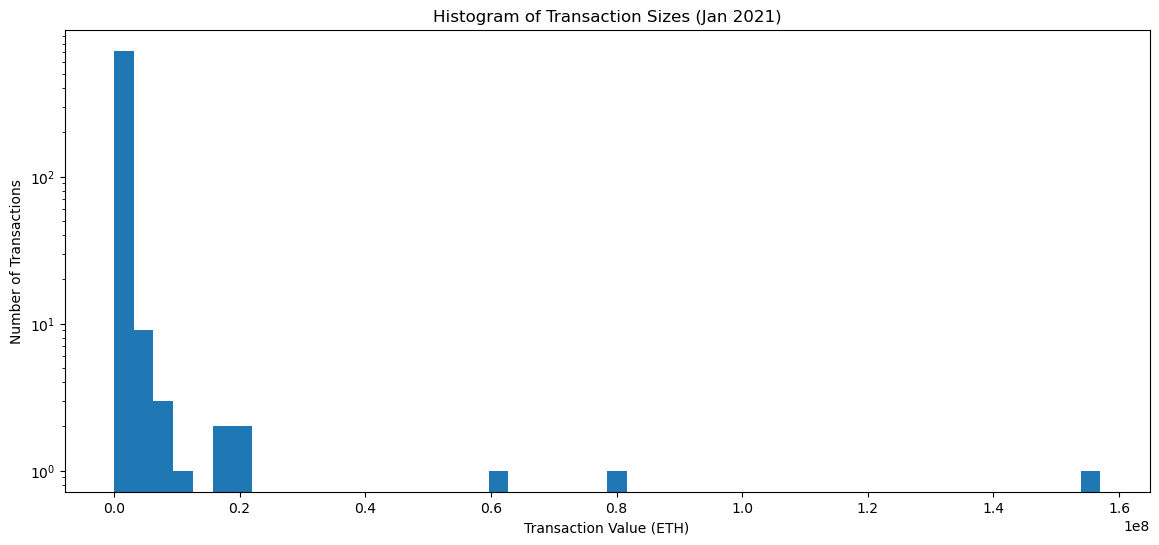

In [73]:
plt.figure(figsize=(14,6))
plt.hist(transactions_in_jan_2021["Transaction Value (ETH)"],bins=50)
plt.xlabel("Transaction Value (ETH)")
plt.ylabel("Number of Transactions")
plt.yscale("log")
plt.title("Histogram of Transaction Sizes (Jan 2021)")

From the first 2 bar graphs, it is clear that there was a significant and sudden increase in daily Transaction counts on 25 Jan 2021 only, which caused a similar effect on daily Transaction Value on the same day. This likely signifies illicit activity such as "pumping and dumping".

From the histogram of transaction sizes over the same month and year, there were a few outliers which had a much higher transaction value as compared to other transactions. This is further proof of the illicit "pump and dump" activities.